In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

c:\Users\luka\source\repos\BrainTumorDetection\BrainTumorDetection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
root_dir = "./data/dataset"
deleted = 0
for dirpath, dirnames, filenames in os.walk(root_dir):
    for file in filenames:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            full_path = os.path.join(dirpath, file)
            img = cv2.imread(full_path)
            if img is not None and img.shape[0] == 256 and img.shape[1] == 256:
                os.remove(full_path)
                deleted += 1

print(f"Deleted {deleted} image(s) of size 256x256.")


In [ ]:
class DataLoaderSeg(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.mask_dir = image_dir.replace("images", "masks")

        self.imgs = sorted(os.listdir(image_dir))
        self.image_paths = []
        self.mask_paths = []

        for i in range(len(self.imgs)):
          self.image_paths.append(self.image_dir+"/"+self.imgs[i])
          self.mask_paths.append(self.mask_dir+"/"+self.imgs[i])


    def __getitem__(self, ind):
        img = cv2.imread(self.image_paths[ind], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[ind], cv2.IMREAD_GRAYSCALE)

        img_tensor = torch.from_numpy(img).float().unsqueeze(0) / 255.0
        mask_tensor = torch.from_numpy(mask).float().unsqueeze(0) / 255.0
        return img_tensor, mask_tensor

    def __len__(self):
        return len(self.image_paths)

    def train_test_split(self):
        test_size=0.2
        random_state=42
        shuffle=True
        x_train, x_test, y_train, y_test = train_test_split(
            self.image_paths, self.mask_paths,
            test_size=test_size, random_state=random_state, shuffle=shuffle
        )
        return x_train, x_test, y_train, y_test

dataset = DataLoaderSeg("./data/dataset/images")
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x_train,x_test,y_train,y_test = dataset.train_test_split()


2439
2439
610
610
Iimg torch.Size([8, 1, 512, 512])
Mask: torch.Size([8, 1, 512, 512])
2.7.0+cu118
True
11.8
1


In [ ]:
model = smp.Unet(encoder_depth=5, in_channels=1, classes=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.load_state_dict(torch.load("./weights/manual/final.pkl"))
model.to(device)
crnosabelo=58
pos_weight = torch.tensor([crnosabelo]).to(device)
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
learning_rate = 0.0001
from ML_Utils import get_accuracy, plot_curve, keep_store_dict, store_dict_to_disk
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
def test(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for batch_num, (x, y) in enumerate(test_loader, 0):
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            test_acc += get_accuracy(y_hat, y)
    return test_acc / batch_num

def train(model, num_epochs, train_loader, store_dict, test_loader=None):
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0
        model = model.train()
        for batch_num, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            loss = loss_function(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(y_hat=y_hat, y=y)
        epoch_loss = train_running_loss / batch_num
        epoch_acc = train_acc / batch_num
        store_dict = keep_store_dict(curve=epoch_loss, label='train_loss', store_dict=store_dict)
        store_dict = keep_store_dict(curve=epoch_acc, label='train_acc', store_dict=store_dict)
        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.3f' % (epoch, epoch_loss, epoch_acc))
        torch.save(model.state_dict(),f"./weights/automatic/epoch_{epoch}.pkl")
        if test_loader is not None:
            test_acc = test(model=model, test_loader=test_loader)
            store_dict = keep_store_dict(curve=test_acc, label='test_acc', store_dict=store_dict)
    return store_dict

while True:
    a = input("Train model (from scratch)? y/n")
    if a.lower()=="y":
        train(model,25,dataloader,{})
        break
    elif a.lower()=="n":
        break



Using device: cuda
Epoch: 0 | Loss: 0.5948 | Train Accuracy: 0.864
Epoch: 1 | Loss: 0.5607 | Train Accuracy: 0.879
Epoch: 2 | Loss: 0.5298 | Train Accuracy: 0.889
Epoch: 3 | Loss: 0.5009 | Train Accuracy: 0.897
Epoch: 4 | Loss: 0.4769 | Train Accuracy: 0.904
Epoch: 5 | Loss: 0.4582 | Train Accuracy: 0.909
Epoch: 6 | Loss: 0.4356 | Train Accuracy: 0.913
Epoch: 7 | Loss: 0.4199 | Train Accuracy: 0.917
Epoch: 8 | Loss: 0.4049 | Train Accuracy: 0.920
Epoch: 9 | Loss: 0.3917 | Train Accuracy: 0.923
Epoch: 10 | Loss: 0.3813 | Train Accuracy: 0.925
Epoch: 11 | Loss: 0.3646 | Train Accuracy: 0.926
Epoch: 12 | Loss: 0.3553 | Train Accuracy: 0.929
Epoch: 13 | Loss: 0.3441 | Train Accuracy: 0.930


KeyboardInterrupt: 

Using device: cuda


C:\Users\luka\AppData\Local\Temp\ipykernel_40508\3131984469.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  axs[3].imshow(np.array(output.cpu())[0, 0], cmap="gray")


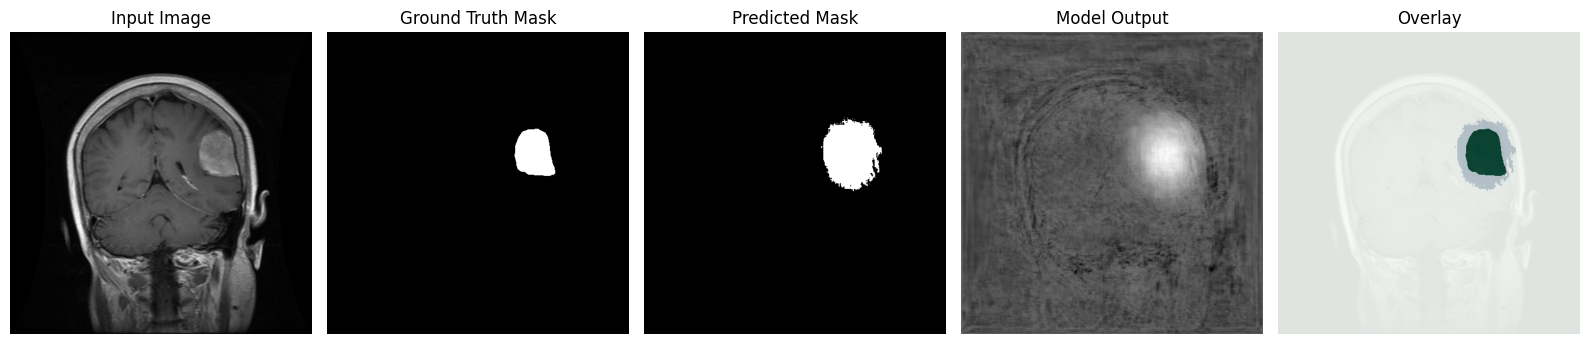

tensor([1.0000])
-8.195499
10.193806
-1.9883068


C:\Users\luka\AppData\Local\Temp\ipykernel_40508\3131984469.py:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  print(np.array(output.cpu())[0,0].min())
C:\Users\luka\AppData\Local\Temp\ipykernel_40508\3131984469.py:72: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  print(np.array(output.cpu())[0,0].max())
C:\Users\luka\AppData\Local\Temp\ipykernel_40508\3131984469.py:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False faile

In [10]:
model = smp.Unet(encoder_depth=5, in_channels=1, classes=1)
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load image and mask
inde = random.randint(1,300)
img_path = f"./data/dataset/images/{inde}.png"
mask_path = f"./data/dataset/masks/{inde}.png"

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Preprocess
img_tensor = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0) / 255.0
mask_tensor = torch.from_numpy(mask).float().unsqueeze(0).unsqueeze(0) / 255.0

# Move to device
img_tensor = img_tensor.to(device)
mask_tensor = mask_tensor.to(device)

model.load_state_dict(torch.load("./weights/manual/improved.pkl"))
model.to(device)

# Model inference
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred_mask = torch.sigmoid(output) > 0.96

# Move to CPU and numpy for plotting
img_np = img_tensor.cpu().squeeze().numpy()
mask_np = mask_tensor.cpu().squeeze().numpy()
pred_np = pred_mask.cpu().squeeze().numpy()

# Plot side-by-side + overlay
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

# Original grayscale input
axs[0].imshow(img_np, cmap='gray')
axs[0].set_title("Input Image")
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(mask_np, cmap='gray')
axs[1].set_title("Ground Truth Mask")
axs[1].axis('off')

# Predicted binary mask
axs[2].imshow(pred_np, cmap='gray')
axs[2].set_title("Predicted Mask")
axs[2].axis('off')

# Raw output (logits)
axs[3].imshow(np.array(output.cpu())[0, 0], cmap="gray")
axs[3].set_title("Model Output")
axs[3].axis("off")

# Composite overlay: input + pred (blue) + ground truth (green)
axs[4].imshow(img, cmap='gray')
axs[4].imshow(pred_np, cmap='Blues', alpha=0.7)
axs[4].imshow(mask_np, cmap='Greens', alpha=0.7)
axs[4].set_title("Overlay")
axs[4].axis('off')

plt.tight_layout()
plt.show()

print(torch.sigmoid(torch.Tensor([output.cpu()[0,0].max()])))

print(np.array(output.cpu())[0,0].min())
print(np.array(output.cpu())[0,0].max())
print(np.array(output.cpu())[0,0].mean())


plt.show()

In [14]:
def accuracy(prediction, maskfr):
    prediction = (prediction > 127).astype(np.uint8)
    maskfr = (maskfr > 127).astype(np.uint8)

    sM = np.sum(maskfr == 1)


    # Compute values
    TP = np.sum((prediction == 1) & (maskfr == 1))
    TN = np.sum((prediction == 0) & (maskfr == 0))
    FP = np.sum((prediction == 1) & (maskfr == 0))
    FN = np.sum((prediction == 0) & (maskfr == 1))

    total = prediction.size
    return FP / sM, FN / total, TP / sM, TN / total

In [ ]:
model1 = smp.Unet(encoder_depth=5, in_channels=1, classes=1)
model1.load_state_dict(torch.load("./weights/manual/improved.pkl"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)

def evaluate_model(model, x_test_paths, y_test_paths):
    model.eval()
    total_FP, total_FN, total_TP, total_TN = 0.0, 0.0, 0.0, 0.0

    with torch.no_grad():
        for img_path, mask_path in zip(x_test_paths, y_test_paths):
            # Load grayscale image and mask (512x512)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Normalize and convert to tensor [1, 1, 512, 512]
            img_tensor = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0) / 255.0
            img_tensor = img_tensor.to(device)

            # Predict
            output = model(img_tensor)
            pred = torch.sigmoid(output).cpu().numpy()[0, 0] * 255  # convert to [0–255] range

            # Compute accuracy
            FP, FN, TP, TN = accuracy(pred, mask)
            total_FP += FP
            total_FN += FN
            total_TP += TP
            total_TN += TN

    num_samples = len(x_test_paths)
    print("\n=== Test Accuracy Metrics ===")
    avg_FP = total_FP / (num_samples * 58)
    avg_FN = total_FN / num_samples
    avg_TP = total_TP / num_samples
    avg_TN = total_TN / num_samples

    print(f"Avg FP / sum(M): {avg_FP:.4f}")
    print(f"Avg FN / total: {avg_FN:.4f}")
    print(f"Avg TP / sum(M): {avg_TP:.4f}")
    print(f"Avg TN / total: {avg_TN:.4f}")

    # Calculate Precision, Recall, and F1 Score
    precision = avg_TP / (avg_TP + avg_FP) if (avg_TP + avg_FP) != 0 else 0
    recall = avg_TP / (avg_TP + avg_FN) if (avg_TP + avg_FN) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")




evaluate_model(model1,x_test,y_test)



#=== Test Accuracy Metrics ===
#Avg FP / sum(M): 8.6423
#Avg FN / total: 0.0004
#Avg TP / sum(M): 0.9551
#Avg TN / total: 0.9039


=== Test Accuracy Metrics ===
Avg FP / sum(M): 0.1354
Avg FN / total: 0.0003
Avg TP / sum(M): 0.9586
Avg TN / total: 0.9102
Precision: 0.8763
Recall: 0.9997
F1 Score: 0.9339


'\n=== Test Accuracy Metrics ===\nAvg FP / sum(M): 8.6423\nAvg FN / total: 0.0004\nAvg TP / sum(M): 0.9551\nAvg TN / total: 0.9039\n'